# The Multi-layer Perceptron

### The Multi-layer Perceptron network, consisting of multiple layers of connected neurons.

<img src="mlp.png" width=400 height=400 />

## Universal Approximators

__It is possible to show mathematically that even with a single-hidden-layer network, given enough nodes,<br> and the right set of weights, we can model any function__

## How to obtain non-linear classifier?

- We can overcome the limitations of linear models by incorporating one or more hidden layers. <br> <br>
- The easiest way to do this is to stack many fully connected layers on top of one another.

### What about the activation function?

 - Activation functions decide whether a neuron should be activated or not <br>
   by calculating the weighted sum and further adding bias to it. <br> <br> 
 - Binary step activation function (threshold activation function) is not differentiable. <br> <br> 
 - We need to use an activation function that can be differentiated. 

### Common activation functions in neural networks include:

- **The sigmoid function**, which maps any input to a value between 0 and 1.
- **The hyperbolic tangent (or tanh) function**, which maps inputs to a value between -1 and 1.
- **The rectified linear unit (or ReLU)**, which maps any negative input to 0 and leaves any positive input unchanged.
- **The softmax function**, which converts a vector of inputs to a vector whose elements range from 0 and 1 and collectively sum to 1.

<img src="activ.fun.png" width=500 height=500 />

## The Multi-layer Perceptron Algorithm

<img src="mlp_algorithm.png" width=500 height=500 />

## The forward pass

<img src="fwd.png" width=500 height=500 />

### Learning as loss minimization

<img src="minim_loss.png" width=500 height=500 />

## The backward pass

<img src="bwd0.png" width=500 height=500 />

<img src="bwd1.png" width=500 height=500 />

<img src="bwd2.png" width=500 height=500 />

<img src="bwd3.png" width=500 height=500 />

<img src="s.png" width=300 height=300 />

<img src="bwd4.png" width=500 height=500 />

## Neural Network Regression Implementation

In [27]:
import numpy as np

class mlp:
    """ A Multi-Layer Perceptron"""
    
    def __init__(self,inputs,targets,nhidden,beta=1,momentum=0.9,outtype='logistic'):
        """ Constructor """
        # Set up network size
        self.nin = np.shape(inputs)[1]
        self.nout = np.shape(targets)[1]
        self.ndata = np.shape(inputs)[0]
        self.nhidden = nhidden

        self.beta = beta
        self.momentum = momentum
        self.outtype = outtype
    
        # Initialise network
        self.weights1 = (np.random.rand(self.nin+1,self.nhidden)-0.5)*2/np.sqrt(self.nin)
        self.weights2 = (np.random.rand(self.nhidden+1,self.nout)-0.5)*2/np.sqrt(self.nhidden)

    def earlystopping(self,inputs,targets,valid,validtargets,eta,niterations=100):
    
        valid = np.concatenate((valid,-np.ones((np.shape(valid)[0],1))),axis=1)
        
        old_val_error1 = 100002
        old_val_error2 = 100001
        new_val_error = 100000
        
        count = 0
        while (((old_val_error1 - new_val_error) > 0.001) or ((old_val_error2 - old_val_error1)>0.001)):
            count+=1
            print (count)
            self.mlptrain(inputs,targets,eta,niterations)
            old_val_error2 = old_val_error1
            old_val_error1 = new_val_error
            validout = self.mlpfwd(valid)
            new_val_error = 0.5*np.sum((validtargets-validout)**2)
            
        print ("Stopped", new_val_error,old_val_error1, old_val_error2)
        return new_val_error
    	
    def mlptrain(self,inputs,targets,eta,niterations):
        """ Train the thing """    
        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((self.ndata,1))),axis=1)
        change = range(self.ndata)
    
        updatew1 = np.zeros((np.shape(self.weights1)))
        updatew2 = np.zeros((np.shape(self.weights2)))
            
        for n in range(niterations):
    
            self.outputs = self.mlpfwd(inputs)

            error = 0.5*np.sum((self.outputs-targets)**2)
            if (np.mod(n,100)==0):
                print ("Iteration: ",n, " Error: ",error)

            # Different types of output neurons
            if self.outtype == 'linear':
            	deltao = (self.outputs-targets)/self.ndata
            elif self.outtype == 'logistic':
            	deltao = self.beta*(self.outputs-targets)*self.outputs*(1.0-self.outputs)
            elif self.outtype == 'softmax':
                deltao = (self.outputs-targets)*(self.outputs*(-self.outputs)+self.outputs)/self.ndata 
            else:
            	print ("error")
            
            deltah = self.hidden*self.beta*(1.0-self.hidden)*(np.dot(deltao,np.transpose(self.weights2)))
                      
            updatew1 = eta*(np.dot(np.transpose(inputs),deltah[:,:-1])) + self.momentum*updatew1
            updatew2 = eta*(np.dot(np.transpose(self.hidden),deltao)) + self.momentum*updatew2
            self.weights1 -= updatew1
            self.weights2 -= updatew2
                
            # Randomise order of inputs (not necessary for matrix-based calculation)
            #np.random.shuffle(change)
            #inputs = inputs[change,:]
            #targets = targets[change,:]
            
    def mlpfwd(self,inputs):
        """ Run the network forward """

        self.hidden = np.dot(inputs,self.weights1);
        self.hidden = 1.0/(1.0+np.exp(-self.beta*self.hidden))
        self.hidden = np.concatenate((self.hidden,-np.ones((np.shape(inputs)[0],1))),axis=1)

        outputs = np.dot(self.hidden,self.weights2);

        # Different types of output neurons
        if self.outtype == 'linear':
        	return outputs
        elif self.outtype == 'logistic':
            return 1.0/(1.0+np.exp(-self.beta*outputs))
        elif self.outtype == 'softmax':
            normalisers = np.sum(np.exp(outputs),axis=1)*np.ones((1,np.shape(outputs)[0]))
            return np.transpose(np.transpose(np.exp(outputs))/normalisers)
        else:
            print ("error")

    def confmat(self,inputs,targets):
        """Confusion matrix"""

        # Add the inputs that match the bias node
        inputs = np.concatenate((inputs,-np.ones((np.shape(inputs)[0],1))),axis=1)
        outputs = self.mlpfwd(inputs)
        
        nclasses = np.shape(targets)[1]

        if nclasses==1:
            nclasses = 2
            outputs = np.where(outputs>0.5,1,0)
        else:
            # 1-of-N encoding
            outputs = np.argmax(outputs,1)
            targets = np.argmax(targets,1)

        cm = np.zeros((nclasses,nclasses))
        for i in range(nclasses):
            for j in range(nclasses):
                cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

        print ("Confusion matrix is:")
        print (cm)
        print ("Percentage Correct: ",np.trace(cm)/np.sum(cm)*100)

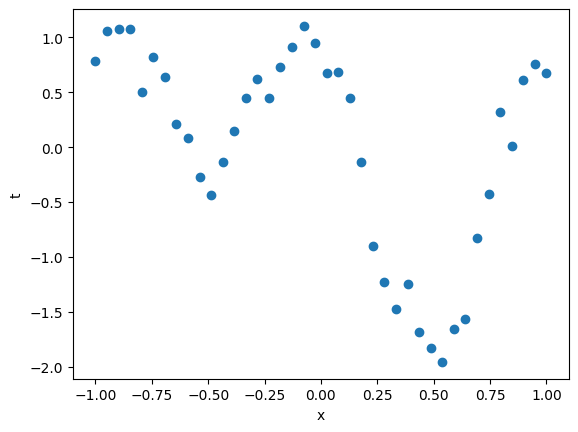

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the data
x = np.linspace(0,1,40).reshape((40,1))
t = np.sin(2*np.pi*x) + np.cos(4*np.pi*x) + np.random.randn(40).reshape((40,1))*0.2
x = (x-0.5)*2

# Split into training, testing, and validation sets
train = x[0::2,:]
test = x[1::4,:]
valid = x[3::4,:]
traintarget = t[0::2,:]
testtarget = t[1::4,:]
validtarget = t[3::4,:]

# Plot the data
plt.plot(x,t,'o')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [29]:
# Perform basic training with a small MLP
print(train.shape)
net = mlp(train,traintarget,3,outtype='linear')
net.mlptrain(train,traintarget,0.25,100)

# Use early stopping
net.earlystopping(train,traintarget,valid,validtarget,0.25)

(20, 1)
Iteration:  0  Error:  9.870188311019637
1
Iteration:  0  Error:  6.305789532498305
2
Iteration:  0  Error:  5.881237999174001
3
Iteration:  0  Error:  5.002743431969864
4
Iteration:  0  Error:  2.0107818114247786
5
Iteration:  0  Error:  1.2504054984996358
6
Iteration:  0  Error:  1.2154349901190071
7
Iteration:  0  Error:  1.1862998588276767
8
Iteration:  0  Error:  1.1534680193974127
9
Iteration:  0  Error:  1.1131839808574546
10
Iteration:  0  Error:  1.0600530803843677
11
Iteration:  0  Error:  0.988903381022849
12
Iteration:  0  Error:  0.9027999002317708
13
Iteration:  0  Error:  0.8183407942470569
14
Iteration:  0  Error:  0.752384813127488
15
Iteration:  0  Error:  0.7070597439826645
16
Iteration:  0  Error:  0.6754761861012686
17
Iteration:  0  Error:  0.6510571836185733
18
Iteration:  0  Error:  0.6297834478593941
19
Iteration:  0  Error:  0.6096797075564665
20
Iteration:  0  Error:  0.5901874201388351
21
Iteration:  0  Error:  0.5714003014969555
22
Iteration:  0  Er

0.46701060442373504

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

In [ ]:
# Make some training data
n = 20
X = np.linspace(0., 20.0, n).reshape((n, 1)) - 10
T = 0.2 + 0.05 * (X + 10) + 0.4 * np.sin(X + 10) + 0.2 * np.random.normal(size=(n, 1))

# Make some testing data
Xtest = X + 0.1 * np.random.normal(size=(n, 1))
Ttest = 0.2 + 0.05 * (X + 10) + 0.4 * np.sin(Xtest + 10) + 0.2 * np.random.normal(size=(n, 1))

nSamples = X.shape[0]
nOutputs = T.shape[1]

In [ ]:
plt.plot(X, T, label='Training Data')
plt.plot(Xtest, Ttest, label='Testing Data')
plt.legend();

In [ ]:
# Set parameters of neural network
nHiddens = 10

rhoh = 0.5
rhoo = 0.1

rh = rhoh / (nSamples * nOutputs)
ro = rhoo / (nSamples * nOutputs)

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1 * 2 * (np.random.uniform(size=(1 + 1, nHiddens)) - 0.5)
W = 0.1 * 2 * (np.random.uniform(size=(1 + nHiddens, nOutputs)) - 0.5)

# Add constant column of 1's
def addOnes(A):
    return np.insert(A, 0, 1, axis=1)

X1 = addOnes(X)
Xtest1 = addOnes(Xtest)

# Take nSteps steepest descent steps in gradient descent search in mean-squared-error function
nSteps = 30000

# collect training and testing errors for plotting
errorTrace = np.zeros((nSteps, 2))

fig = plt.figure(figsize=(10 ,8))

for step in range(nSteps):

    # Forward pass on training data
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = Z1 @ W

    # Error in output
    error = T - Y

    # Backward pass - the backpropagation and weight update steps
    V = V + rh * X1.T @ ( ( error @ W[1:, :].T) * (1 - Z**2))
    W = W + ro * Z1.T @ error

    # error traces for plotting
    errorTrace[step, 0] = np.sqrt(np.mean((error**2)))
    
    Ytest = addOnes(np.tanh(Xtest1 @ V)) @ W  #!! Forward pass in one line
    errorTrace[step, 1] = np.sqrt(np.mean((Ytest - Ttest)**2))

    if step % 1000 == 0 or step == nSteps-1:
        
        plt.clf()
        
        # Plot the trace of the mean squared error on training and testing data
        plt.subplot(3, 1, 1)
        plt.plot(errorTrace[:step, :])
        plt.ylim(0, 0.7)
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend(('Train','Test'), loc='upper left')
        
        # Plot the training and testing data, and 
        # the output of our neural network model on the test data
        plt.subplot(3, 1, 2)
        plt.plot(X, T, 'o-', Xtest, Ttest, 'o-', Xtest, Ytest, 'o-')
        plt.xlim(-10, 10)
        plt.legend(('Training','Testing','Model'), loc='upper left')
        plt.xlabel('$x$')
        plt.ylabel('Actual and Predicted $f(x)$')
        
        # Plot the output of the hidden layer for each training sample
        plt.subplot(3, 1, 3)
        plt.plot(X, Z)
        plt.ylim(-1.1, 1.1)
        plt.xlabel('$x$')
        plt.ylabel('Hidden Unit Outputs ($z$)')

        plt.tight_layout()
        
        ipd.clear_output(wait=True)
        ipd.display(fig)
ipd.clear_output(wait=True)